In [1]:
"""
This script is used to perform differential proportion analysis on the cell type numbers table generated by stemi_create_celltype_composition_tables.R

authors: Roy Oelen
"""

'\nThis script is used to perform differential proportion analysis on the cell type numbers table generated by stemi_create_celltype_composition_tables.R\n\nauthors: Roy Oelen\n'

In [2]:
# import all the libraries
import tensorflow as tf
import pandas as pd
import csv
import pickle as pkl
import matplotlib.pyplot as plt
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod
import os

2024-02-15 14:21:20.492830: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 14:21:20.824538: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 14:21:23.029957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 14:21:23.033208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 14:21:23.414237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [15]:
# create class we will use
class ProportionAnalyzer:
    """
    Object to load the count data, set parameters and fetch results
    """
    def __init__(self, count_data_loc, treatment_column='inflammation_status', exclusion_columns=[], covariates_columns=[], fdr=0.05, sep='\t', reference=None):
        """constructor
        
        Parameters
        ----------
        count_data_loc : str
            The location of the count data to load
        treatment_column : str, optional
            The column that contains the data upon which to compare conditions or treatments
        exclusion_columns : list, optional
            The columns that are removed from the count data (for example covariates that are not used, or cell types to exclude)
        covariates_columns : list, optional
            The columns that contain the covariates to use
        fdr : float, optional
            The FDR cutoff to use
        sep : str, optional
            The separator for reading the count data
        
        """
        # set up class variables from constructor
        self.__count_data_loc = count_data_loc
        self.__treatment_column = treatment_column
        self.__exclusion_columns = exclusion_columns
        self.__covariates_columns = covariates_columns
        self.__fdr = fdr
        self.__sep = sep
        # other variables that will be populated later
        self.__raw_counts = None
        self.__filtered_counts = None
        self.__sccoda = None
        self.__reference = reference
        # set up the count data
        self.__setup_count_data()
        # set up the reference
        if self.__reference is None:
            self.__setup_reference()
        # of course we will at some point have a result
        self.__has_run = False
        self.__formula = None
        self.__model = None
        self.__result = None
        # set up a seed so that the results are always the same
        tf.random.uniform([1], seed=7777)
        tf.random.set_seed(7777)
            
    def __setup_reference(self):
        """set up the reference for the model
        
        """
        # get the unique entries possible
        levels = self.__filtered_counts[self.__treatment_column].unique()
        # the first level is the reference
        self.__reference = levels[0]
    
    
    def __make_columns_safe(self):
        """rename columns so that they don't contain quotes
        
        """
        # get the current column names
        current_colnames = self.__raw_counts.columns
        # create a new list of columns
        new_colnames = []
        # replace each occurence
        for old_column in current_colnames:
            # replace
            new_column = old_column.replace('"', '')
            new_column = new_column.replace('.', '_')
            # add to list
            new_colnames.append(new_column)
        
        # zip to create a mapping from the old to the new column names
        columnname_mapping = dict(zip(current_colnames, new_colnames))
        # and do the actual renaming
        self.__raw_counts.rename(columnname_mapping, axis = 'columns', inplace = True)
        
    
    def __setup_count_data(self):
        """setup the count data to be used for the analysis
        
        """
        # read the count data
        self.__raw_counts = pd.read_csv(self.__count_data_loc, sep = self.__sep, quoting = csv.QUOTE_NONE)
        # make the columns safe
        self.__make_columns_safe()
        # make a copy from which we will remove some columns
        self.__filtered_counts = self.__raw_counts.copy(deep = True)
        # remove the columns that we don't need
        self.__filtered_counts.drop(self.__exclusion_columns, axis = 'columns', inplace = True)
        # set up the sccoda object
        self.__sccoda = dat.from_pandas(self.__filtered_counts, covariate_columns = self.__covariates_columns + [self.__treatment_column])
    
    
    def create_boxplot(self):
        """plot the counts
        
        """
        # create the plot
        viz.boxplots(self.__sccoda, feature_name = self.__treatment_column)
        plt.tight_layout()
    
    
    def run_model(self):
        """run the model
        
        """
        # set up the covariates
        covariates_formula = ''
        for covariate in self.__covariates_columns:
            covariates_formula = ''.join([covariates_formula, covariate, ' + '])
        # set up treatment
        treatment_formula = "C(" + self.__treatment_column + ", Treatment('" + self.__reference + "'))"
        # create formula
        self.__formula = covariates_formula + treatment_formula
        # create the model
        self.__model = mod.CompositionalAnalysis(self.__sccoda, formula = self.__formula)
        # run the analysis
        self.__result = self.__model.sample_hmc()
        # we ran the analysis, so let's say so
        self.__has_run = True
        
    
    def get_result(self):
        """return the result of the model
        
        Returns
        -------
        result
           The result of the compositional analysis
        """
        # check if we have run the model
        if self.__has_run:
            return self.__result
        else:
            print('model has not been run, returning None')
            return None
    
    
    def get_summary(self, fdr=None):
        """get a summary of the results for a specific FDR
        
        Parameters
        ----------
        fdr : float, optional
            The FDR cutoff to use
        
        Returns
        -------
        result
           summary of the compositional analysis
        """
        # see if an fdr was supplied
        fdr_to_use=None
        if fdr is None:
            fdr_to_use = self.__fdr
        else:
            fdr_to_use = fdr

        # check if we have run the model
        if self.__has_run:
            # if so, return a summary
            summary = self.__result.summary_prepare([fdr_to_use])
            return(summary)
        else:
            print('model has not been run, returning None')
            return None
        
    
    def get_raw_counts(self):
        """get the raw counts
        
        Returns
        -------
        pandas.DataFrame
           The raw counts before filtering columns
        
        """
        return self.__raw_counts
    
    
    def get_counts(self):
        """get the cell counts
        
        Returns
        -------
        pandas.Dataframe
            The filtered cell counts
        
        """
        return self.__filtered_counts
    
    
    def get_sccoda(self):
        """get the sccoda input object
        
        Returns
        -------
        sccoda
            The filtered cell counts
        
        """
        return self.__sccoda
    
    
    def get_fdr(self):
        """get the fdr set
        
        Returns
        -------
        float
            The fdr used
        
        """
        return self.__fdr

In [16]:
# the locations of the cell proportion files
proportions_table_loc = '/groups/umcg-franke-scrna/tmp03/releases/blokland-2020/v1/cell_type_composition/cell_number_tables/'
# locations of the specific cell type tables
proportions_table_lowres_loc = ''.join([proportions_table_loc, 'stemi_cell_numbers_lowres.tsv'])
proportions_table_highres_loc = ''.join([proportions_table_loc, 'stemi_cell_numbers_highres.tsv'])
# the column of the sample
sample_column = 'assignment_final'
# the column of the inflammation status
condition_column = 'timepoint_final'
# the FDR to use
fdr = 0.05

/home/umcg-roelen/miniconda3/envs/sccoda_env/lib/python3.9/site-packages/sccoda/util/data_visualization.py:335: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


Automatic reference selection! Reference cell type set to DC
Zero counts encountered in data! Added a pseudocount of 0.5.


2024-02-15 14:36:07.075843: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8b6800bd20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-15 14:36:07.075912: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
  0%|                                                                                                                                                                                                        | 0/20000 [00:00<?, ?it/s]2024-02-15 14:36:07.221849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708007768.095874  840469 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-15 14:36:08.113079: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPrio

MCMC sampling finished. (321.731 sec)
Acceptance rate: 43.2%


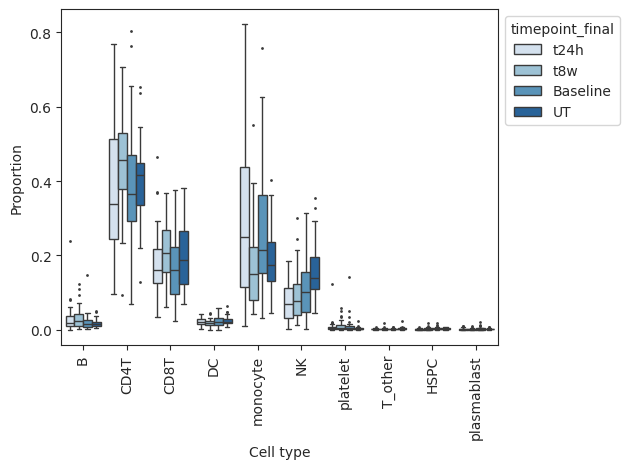

In [17]:
# perform the analysis for the compartment
compartment_analysis_wmetadata = ProportionAnalyzer(count_data_loc = proportions_table_lowres_loc, treatment_column=condition_column, exclusion_columns = [sample_column], covariates_columns = ['sex', 'age'], reference = 'Baseline')
# show the plot
compartment_analysis_wmetadata.create_boxplot()
# do the analysis
compartment_analysis_wmetadata.run_model()
# get the result
compartment_summary_005_wmetadata = compartment_analysis_wmetadata.get_summary()

In [18]:
compartment_summary_005_wmetadata[0]

,Final Parameter,HDI 3%,HDI 97%,SD,Expected Sample
Cell Type,,,,,
B,-0.332,-0.332,-0.332,0.0,46.662664
CD4T,-0.096,-0.096,-0.096,0.0,59.083067
CD8T,-0.528,-0.528,-0.528,0.0,38.357281
DC,-0.674,-0.674,-0.674,0.0,33.146740
monocyte,-0.704,-0.704,-0.704,0.0,32.167106
NK,0.431,0.431,0.431,0.0,100.077448
platelet,1.201,1.201,1.201,0.0,216.143894
T_other,1.432,1.432,1.432,0.0,272.310882
HSPC,-1.137,-1.137,-1.137,0.0,20.862314


In [19]:
compartment_summary_005_wmetadata[1]

Final Parameter  \
Covariate                                         Cell Type                      
sex[T.M]                                          B                   0.298505   
                                                  CD4T               -0.324590   
                                                  CD8T                0.566956   
                                                  DC                  0.000000   
                                                  monocyte           -0.281642   
                                                  NK                 -0.602047   
                                                  platelet            0.839041   
                                                  T_other             0.212142   
                                                  HSPC               -0.713988   
                                                  plasmablast         0.938962   
C(timepoint_final, Treatment('Baseline'))[T.UT]   B                   0.056031   
                                                  CD4T                0.086047   
                                                  CD8T               -0.210697   
                                                  DC                  0.000000   
                                                  monocyte            0.004136   
                                                  NK                  0.217638   
                                                  platelet           -0.527895   
                                                  T_other            -0.165317   
                                                  HSPC                0.164708   
                                                  plasmablast        -0.068666   
C(timepoint_final, Treatment('Baseline'))[T.t24h] B                   0.173868   
                                                  CD4T               -0.634178   
                                                  CD8T                0.315938   
                                                  DC                  0.000000   
                                                  monocyte            0.074701   
                                                  NK                  0.152740   
                                                  platelet           -0.374176   
                                                  T_other             0.358095   
                                                  HSPC                0.605534   
                                                  plasmablast         0.388129   
C(timepoint_final, Treatment('Baseline'))[T.t8w]  B                   0.149473   
                                                  CD4T               -0.020760   
                                                  CD8T               -0.412576   
                                                  DC                  0.000000   
                                                  monocyte           -0.142175   
                                                  NK                  0.395672   
                                                  platelet           -0.438958   
                                                  T_other             0.369991   
                                                  HSPC               -0.086877   
                                                  plasmablast        -0.354873   
age                                               B                  -0.087620   
                                                  CD4T               -0.272845   
                                                  CD8T               -0.508698   
                                                  DC                  0.000000   
                                                  monocyte           -0.065309   
                                                  NK                 -0.583044   
                                                  platelet            0.278638   
                                             

/home/umcg-roelen/miniconda3/envs/sccoda_env/lib/python3.9/site-packages/sccoda/util/data_visualization.py:335: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


Automatic reference selection! Reference cell type set to cDC2
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:26<00:00, 44.80it/s]


MCMC sampling finished. (503.937 sec)
Acceptance rate: 35.1%


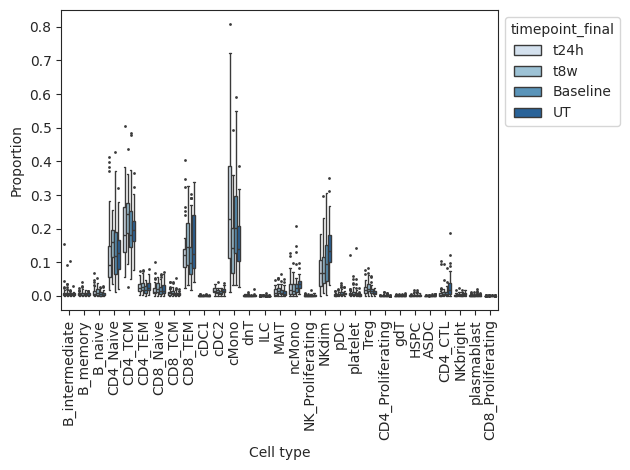

In [20]:
# perform the analysis for the compartment
highres_analysis_wmetadata = ProportionAnalyzer(count_data_loc = proportions_table_highres_loc, treatment_column=condition_column, exclusion_columns = [sample_column], covariates_columns = ['sex', 'age'], reference = 'Baseline')
# show the plot
highres_analysis_wmetadata.create_boxplot()
# do the analysis
highres_analysis_wmetadata.run_model()
# get the result
highres_summary_005_wmetadata = highres_analysis_wmetadata.get_summary()

In [21]:
highres_summary_005_wmetadata[0]

,Final Parameter,HDI 3%,HDI 97%,SD,Expected Sample
Cell Type,,,,,
B_intermediate,-0.332,-0.332,-0.332,0.0,17.915801
B_memory,-0.096,-0.096,-0.096,0.0,22.684527
B_naive,-0.528,-0.528,-0.528,0.0,14.727007
CD4_Naive,-0.674,-0.674,-0.674,0.0,12.726457
CD4_TCM,-0.704,-0.704,-0.704,0.0,12.350333
CD4_TEM,0.431,0.431,0.431,0.0,38.424030
CD8_Naive,1.201,1.201,1.201,0.0,82.986923
CD8_TCM,1.432,1.432,1.432,0.0,104.551842
CD8_TEM,-1.137,-1.137,-1.137,0.0,8.009938


In [22]:
highres_summary_005_wmetadata[1]

Final Parameter  HDI 3%  HDI 97%   SD  \
Covariate Cell Type                                                  
sex[T.M]  B_intermediate            0.298540   0.299    0.299  0.0   
          B_memory                 -0.324678  -0.325   -0.325  0.0   
          B_naive                   0.566632   0.567    0.567  0.0   
          CD4_Naive                -0.281861  -0.282   -0.282  0.0   
          CD4_TCM                  -0.602568  -0.603   -0.603  0.0   
...                                      ...     ...      ...  ...   
age       ASDC                     -0.548217  -0.548   -0.548  0.0   
          CD4_CTL                   0.643828   0.644    0.644  0.0   
          NKbright                  0.246119   0.246    0.246  0.0   
          plasmablast              -0.596049  -0.596   -0.596  0.0   
          CD8_Proliferating         0.517476   0.517    0.517  0.0   

                             Inclusion probability  Expected Sample  \
Covariate Cell Type                                                   
sex[T.M]  B_intermediate                       1.0        22.486864   
          B_memory                             1.0        15.267300   
          B_naive                              1.0        24.167858   
          CD4_Naive                            1.0         8.939955   
          CD4_TCM                              1.0         6.295425   
...                                            ...              ...   
age       ASDC                                 1.0         2.768517   
          CD4_CTL                              1.0        74.990149   
          NKbright                             1.0         7.445785   
          plasmablast                          1.0         7.046140   
          CD8_Proliferating                    1.0       102.925442   

                             log2-fold change  
Covariate Cell Type                            
sex[T.M]  B_intermediate             0.327850  
          B_memory                  -0.571264  
          B_naive                    0.714625  
          CD4_Naive                 -0.509491  
          CD4_TCM                   -0.972174  
...                                       ...  
age       ASDC                      -0.730540  
          CD4_CTL                    0.989218  
          NKbright                   0.415446  
          plasmablast               -0.799546  
          CD8_Proliferating          0.806931  

[145 rows x 7 columns]

In [24]:
# save the results
result_output_loc = '/groups/umcg-franke-scrna/tmp03/releases/blokland-2020/v1/cell_type_composition/sccoda/'
# specific files
result_compartment_summary_005_wmetadata_general_summary_loc = ''.join([result_output_loc, 'stemi_sccoda_lowres_005_age_sex', '_general_summary_round1.tsv'])
result_compartment_summary_005_wmetadata_covariate_summary_loc = ''.join([result_output_loc, 'stemi_sccoda_lowres_005_age_sex', '_covariate_summary_round1.tsv'])
result_highres_summary_005_wmetadata_general_summary_loc = ''.join([result_output_loc, 'stemi_sccoda_adult_highres_martin_immune_005_age_sex', '_general_summary_round1.tsv'])
result_highres_summary_005_wmetadata_covariate_summary_loc = ''.join([result_output_loc, 'stemi_sccoda_adult_highres_martin_immune_005_age_sex', '_covariate_summary_round1.tsv'])
# write the results
compartment_summary_005_wmetadata[0].to_csv(result_compartment_summary_005_wmetadata_general_summary_loc, sep = '\t')
compartment_summary_005_wmetadata[1].to_csv(result_compartment_summary_005_wmetadata_covariate_summary_loc, sep = '\t')
highres_summary_005_wmetadata[0].to_csv(result_highres_summary_005_wmetadata_general_summary_loc, sep = '\t')
highres_summary_005_wmetadata[1].to_csv(result_highres_summary_005_wmetadata_covariate_summary_loc, sep = '\t')